In [1]:
import os
import shutil
import torch
import torch.utils.data
import torchvision
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import cv2
import copy
import matplotlib.pyplot as plt

import random
import json

from NUTMGS.coco_merger import merge_coco_json

In [2]:
# from https://stackoverflow.com/questions/75326066/coco-annotations-convert-rle-to-polygon-segmentation
def rle_to_coco(annotation: dict) -> list[dict]:
    """Transform the rle coco annotation (a single one) into coco style.
    In this case, one mask can contain several polygons, later leading to several `Annotation` objects.
    In case of not having a valid polygon (the mask is a single pixel) it will be an empty list.
    Parameters
    ----------
    annotation : dict
        rle coco style annotation
    Returns
    -------
    list[dict]
        list of coco style annotations (in dict format)
    """

    annotation["segmentation"] = cocomask.frPyObjects(
        annotation["segmentation"],
        annotation["segmentation"]["size"][0],
        annotation["segmentation"]["size"][1],
    )

    maskedArr = cocomask.decode(annotation["segmentation"])
    contours, _ = cv2.findContours(maskedArr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []

    for contour in contours:
        if contour.size >= 6:
            segmentation.append(contour)

    if len(segmentation) == 0:
        annotation["segmentation"] = []

    else:
        # annotation["bbox"] = annotation["segmentation"]["bbox"]
        # annotation["area"] = annotation["segmentation"]["area"]
        annotation["segmentation"] = []
        for i, seg in enumerate(segmentation):
            annotation["segmentation"].append(
                seg.astype(float).flatten().tolist()
            )
            # annotation["bbox"] = list(cv2.boundingRect(seg))
            # annotation["area"] = cv2.contourArea(seg)
            # annotation["instance_id"] = annotation["id"]
            # annotation["id"] = f"{annotation['id']}_{i}"
            # single_annotation.pop("segmentation")


    return annotation

In [3]:
class TreeLabel(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms

        from contextlib import redirect_stdout
        with redirect_stdout(open(os.devnull, "w")): # get rid of loading print
            self.coco = COCO(annotation)

        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ann_count = {}

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)
    
    def get_ann_counts(self):
        coco = self.coco
        for i in range(len(self.ids)):
            self.ann_count[self.ids[i]] = 0

        for i in range(len(self.ids)):
            ann_ids = coco.getAnnIds(imgIds=self.ids[i])
            # Dictionary: target coco_annotation file for an image
            coco_annotation = coco.loadAnns(ann_ids)
            for ann in coco_annotation:
                if (ann['iscrowd'] == 1):
                    self.ann_count[int(ann['image_id'])] += 1

    
    def export_images(self, offset: int, select, state: str = None):
        exp = []
        coco = self.coco
        for i in select:
            self.ann_count[self.ids[i]] = 0
            img = coco.loadImgs(self.ids[i])[0]
            img['id'] = int(img['id']) + offset
            img.pop('flickr_url')
            img.pop('coco_url')
            img.pop('date_captured')
            if state is not None:
                img['state'] = state

            ann_ids = coco.getAnnIds(imgIds=self.ids[i])
            coco_annotation = coco.loadAnns(ann_ids)
            if len(coco_annotation) > 0:
                exp.append(img)
        
        return exp
    
    def export_annotations(self, offset: int, select, img_offset: int):
        exp = []
        coco = self.coco
        for i in select:
            ann_ids = coco.getAnnIds(imgIds=self.ids[i])
            # Dictionary: target coco_annotation file for an image
            coco_annotation = coco.loadAnns(ann_ids)
            for ann in coco_annotation:
                self.ann_count[int(ann['image_id'])] += 1
                ann['id'] = int(ann['id']) + offset
                ann['image_id'] = int(ann['image_id']) + img_offset
                
                if (ann['iscrowd'] == 1):
                    ann['iscrowd'] = 0 # so we can train on it
                    ann = rle_to_coco(ann)
                    if len(ann["segmentation"]) > 0:
                        exp.append(ann)
                    
                else:
                    print(ann['segmentation'])
        
        return exp
    
    def export_mask(self, output_dir: str):
        for id in range(len(self.ids)):
            coco = self.coco
            ann_ids = coco.getAnnIds(imgIds=self.ids[id])
            path = coco.loadImgs(self.ids[id])[0]['file_name']
            # open the input image
            img = Image.open(os.path.join(self.root, path))

            mask_img = Image.new('L', (img.width, img.height), 0)
            
            # Dictionary: target coco_annotation file for an image
            coco_annotation = coco.loadAnns(ann_ids)
            for ann in coco_annotation:
                for poly in ann['segmentation']:
                    ImageDraw.Draw(mask_img, 'L').polygon(poly, fill=(255))
            
            mask_img.save(os.path.join(output_dir, path))

def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [4]:
# create the correct sections for COCO format
img_written = 0
ann_written = 0

root = 'zonesplits'
zones = [
    'flood_prone_easterncombined_anns_ood',
    'humid_southeasterncombined_anns_ood',
    'hyperarid_westerncombined_anns_id',
    'irrigated_northerncombined_anns_ood',
    'jodhpurcombined_anns_ood',
    'semiarid_eastern_plainscombined_anns_id',
    'subhumid_southern_plains_aravallicombined_anns_id',
    'transitional_inland_drainagecombined_anns_id'
]

for i, file in enumerate(zones):
    train_coco = f'{root}/{file}_train.json'
    image_dir = f'Images'

    train_dataset = TreeLabel(root=image_dir,
                            annotation=train_coco,
                            transforms=get_transform()
                            )
    
    print(f'{train_coco}: {len(train_dataset.ids)}')

    test_coco = f'{root}/{file}_test.json'

    test_dataset = TreeLabel(root=image_dir,
                            annotation=test_coco,
                            transforms=get_transform()
                            )
    
    print(f'{test_coco}: {len(test_dataset.ids)}')

    merge_coco_json([train_coco, test_coco], f'{root}/{file}_merged.json')
    merged_coco = f'{root}/{file}_merged.json'

    merged_dataset = TreeLabel(root=image_dir,
                            annotation=merged_coco,
                            transforms=get_transform()
                            )
    
    print(f'{merged_coco}: {len(merged_dataset.ids)}')

zonesplits/flood_prone_easterncombined_anns_ood_train.json: 210
zonesplits/flood_prone_easterncombined_anns_ood_test.json: 89
zonesplits/flood_prone_easterncombined_anns_ood_merged.json: 287
zonesplits/humid_southeasterncombined_anns_ood_train.json: 104
zonesplits/humid_southeasterncombined_anns_ood_test.json: 90
zonesplits/humid_southeasterncombined_anns_ood_merged.json: 186
zonesplits/hyperarid_westerncombined_anns_id_train.json: 294
zonesplits/hyperarid_westerncombined_anns_id_test.json: 84
zonesplits/hyperarid_westerncombined_anns_id_merged.json: 378
zonesplits/irrigated_northerncombined_anns_ood_train.json: 189
zonesplits/irrigated_northerncombined_anns_ood_test.json: 93
zonesplits/irrigated_northerncombined_anns_ood_merged.json: 260
zonesplits/jodhpurcombined_anns_ood_train.json: 655
zonesplits/jodhpurcombined_anns_ood_test.json: 97
zonesplits/jodhpurcombined_anns_ood_merged.json: 655
zonesplits/semiarid_eastern_plainscombined_anns_id_train.json: 973
zonesplits/semiarid_eastern_p

In [6]:
tifs_wanted = {
    'FLOOD PRONE EASTERN': 113 * 2,
    'HUMID SOUTHEASTERN': 214 * 2,
    'HYPERARID WESTERN': 22 * 2,
    'IRRIGATED NORTHERN': 140 * 2
}

zone_mapping = {
    'Alwar': 'FLOOD PRONE EASTERN',
    'Bharatpur': 'FLOOD PRONE EASTERN',
    'Dhaulpur': 'FLOOD PRONE EASTERN',
    'Karauli': 'FLOOD PRONE EASTERN',
    'Sawai Madhopur': 'FLOOD PRONE EASTERN',
    'Kota': 'HUMID SOUTHEASTERN',
    'Jhalawar': 'HUMID SOUTHEASTERN',
    'Bundi': 'HUMID SOUTHEASTERN',
    'Baran': 'HUMID SOUTHEASTERN',
    'Barmer': 'HYPERARID WESTERN',
    'Bikaner': 'HYPERARID WESTERN',
    'Jaisalmer': 'HYPERARID WESTERN',
    'Sriganganagar': 'IRRIGATED NORTHERN',
    'Hanumangarh': 'IRRIGATED NORTHERN'
}

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shapely
import random

shp_file = './rajasthan_districts/districts_of_karnataka.shp'
data = gpd.read_file(shp_file).to_crs(32643)

print(data)

      geometry_t  ADM1_CODE       ADM2_NAME  EXP2_YEAR DISP_AREA  ADM1_NAME  \
0        Polygon       1506        Dhaulpur       3000        NO  Rajasthan   
1        Polygon       1506           Baran       3000        NO  Rajasthan   
2        Polygon       1506          Jaipur       3000        NO  Rajasthan   
3   MultiPolygon       1506         Udaipur       3000        NO  Rajasthan   
4        Polygon       1506           Dausa       3000        NO  Rajasthan   
5        Polygon       1506       Rajsamand       3000        NO  Rajasthan   
6        Polygon       1506  Sawai Madhopur       3000        NO  Rajasthan   
7        Polygon       1506         Karauli       3000        NO  Rajasthan   
8        Polygon       1506     Hanumangarh       3000        NO  Rajasthan   
9   MultiPolygon       1506           Ajmer       3000        NO  Rajasthan   
10       Polygon       1506           Alwar       3000        NO  Rajasthan   
11       Polygon       1506        Banswara       30

<Axes: >

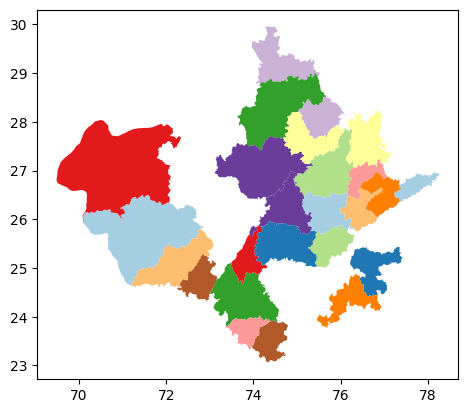

In [2]:
data['color'] = sns.color_palette("Paired", len(data))
data.plot(color=data['color'])

In [3]:
def get_region(shape, key, point):
    for row_id, row in shape.iterrows():
        if row['geometry'].intersects(point):
            return row[key]
        
    return 'unknown'

In [4]:
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler

from rasterio.transform import from_bounds

class Skysat(RasterDataset):
    filename_glob = "*.tif"
    filename_regex = r"()"
    date_format = "%Y%m%d"
    is_image = True
    separate_files = True
    all_bands = ["red", "green", "blue"]
    rgb_bands = ["red", "green", "blue"]
    
    def __getitem__(self, index):
        sample_dict = super().__getitem__(index)

        # Convert image to tensor here, so that we can handle the bands
        # Compute the affine transform for this image
        image = sample_dict['image']

        transform = self.get_transform(sample_dict["bounds"], image.shape[1], image.shape[2])
        sample_dict["transform"] = transform
        return sample_dict

    def get_transform(self, bounds, height, width):
        # Convert a BoundingBox in pixel coordinates to an affine transform
        left, top, right, bottom = bounds.minx, bounds.maxy, bounds.maxx, bounds.miny
        return from_bounds(left, bottom, right, top, width, height)
    
    def plot(self, sample):
#         print(sample)
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0).numpy().astype(int)
#         image = torch.clamp(image / 10000, min=0, max=1).numpy()
#         print(image)
        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

In [15]:
from shapely import Point

dataset = Skysat('./NUTMGS/tifs_for_labeling/rajasthan_top_10_tifs/')

torch.manual_seed(3)
sampler = GridGeoSampler(dataset, size=400, stride=400)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
zones = {}
for i, batch in enumerate(dataloader):
    unbinded = unbind_samples(batch)
    sample = unbinded[0]
    im = sample['image']

    numpixels = im.shape[0] * im.shape[1] * im.shape[2]
    numzero = (im == 0).sum().item()
    ratio = numzero / numpixels
    if ratio < 0.2:
        bds = sample['bounds']
        pt = Point((bds[0] + bds[1]) / 2, (bds[2] + bds[3]) / 2)
        district = get_region(data, 'ADM2_NAME', pt)

        if district in zone_mapping:
            zone = zone_mapping[district]
            zones[zone] = zones.get(zone, 0) + 1
        else:
            zones['UNKNOWN'] = zones.get('UNKNOWN', 0) + 1

print(zones)

{'UNKNOWN': 12115, 'FLOOD PRONE EASTERN': 1942, 'HYPERARID WESTERN': 1262, 'IRRIGATED NORTHERN': 473, 'HUMID SOUTHEASTERN': 443}


In [16]:
import rasterio
import string

f = open('./cvat_uploads/rajasthan_extra.csv', 'w')
f.write('filename,zone\n')

torch.manual_seed(3)
sampler = GridGeoSampler(dataset, size=400, stride=400)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
c = 0
for i, batch in enumerate(dataloader):
    unbinded = unbind_samples(batch)
    sample = unbinded[0]
    im = sample['image']

    numpixels = im.shape[0] * im.shape[1] * im.shape[2]
    numzero = (im == 0).sum().item()
    ratio = numzero / numpixels
    if ratio < 0.2:
        bds = sample['bounds']
        pt = Point((bds[0] + bds[1]) / 2, (bds[2] + bds[3]) / 2)
        district = get_region(data, 'ADM2_NAME', pt)

        if district not in zone_mapping:
            continue
            
        zone = zone_mapping[district]
        if random.random() < tifs_wanted[zone] / zones[zone]:
            rand_str = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10))
            p = f'./cvat_uploads/rajasthan_extra/{rand_str}_chipid{c}.tiff'

            image = sample["image"][[0,1,2]].numpy().astype('uint8')

            with rasterio.open(
                p,
                'w',
                driver='GTiff',
                height=400,
                width=400,
                count=3,  # Assuming im is in C,H,W format
                dtype='uint8',  # Ensure the dtype matches your data
                crs=sample['crs'],
                transform=sample['transform']
            ) as dst:
                dst.write(image)  # Convert tensor to NumPy array for rasterio

            f.write(f'{rand_str}_chipid{c}.tiff,{zone}\n')

            c += 1
            tifs_wanted[zone] -= 1
        zones[zone] -= 1

f.close()
print(zones)
print(tifs_wanted)

{'UNKNOWN': 12115, 'FLOOD PRONE EASTERN': 0, 'HYPERARID WESTERN': 0, 'IRRIGATED NORTHERN': 0, 'HUMID SOUTHEASTERN': 0}
{'FLOOD PRONE EASTERN': 0, 'HUMID SOUTHEASTERN': 0, 'HYPERARID WESTERN': 0, 'IRRIGATED NORTHERN': 0}
